In [21]:
import os
# os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
# import geoopt
import manifolds
import layers.hyp_layers as hyp_layers
import utils.math_utils as pmath
import optimizers
import matplotlib.pyplot as plt
import pandas as pd
# for plt display in notebook
from IPython.display import clear_output

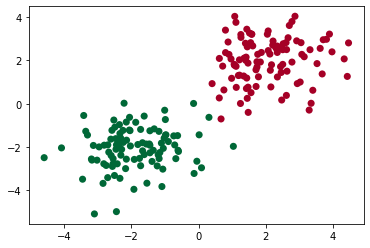

In [22]:
n_data = torch.ones(100, 2)
x0 = torch.normal(2*n_data, 1)
y0 = torch.zeros(100)
x1 = torch.normal(-2*n_data, 1)
y1 = torch.ones(100)

x = torch.cat((x0, x1), 0).type(torch.FloatTensor)  # FloatTensor = 32-bit floating
y = torch.cat((y0, y1), ).type(torch.LongTensor)    # LongTensor = 64-bit integer

plt.scatter(x.detach().numpy()[:, 0], x.detach().numpy()[:, 1], c=y.detach().numpy(), s=50, lw=0, cmap='RdYlGn')
plt.show()

In [23]:
"""
args
"""
class config_args():
    def __init__(self):
        self.manifold = 'PoincareBall' # which manifold to use, can be any of [Euclidean, Hyperboloid, PoincareBall]
        self.dropout = 0.0
        self.bias = 1
        self.c = 8.0
        self.num_layers = 2
        self.cuda = -1 # which cuda device to use (-1 for cpu training)
        self.act = 'relu'
        self.dim = 128 # embedding dimension
        self.task = 'None'
        self.optimizer = 'RiemannianAdam' # which optimizer to use, can be any of [Adam, RiemannianAdam]
        self.lr = 0.01
        self.weight_decay = 0.
        self.epochs = 100
    
args = config_args()
args.feat_dim = x.shape[1]
args.n_classes = 2

# model2decoder = {
#     'GCN': GCNDecoder,
#     'GAT': GATDecoder,
#     'HNN': LinearDecoder,
#     'HGCN': LinearDecoder,
#     'MLP': LinearDecoder,
#     'Shallow': LinearDecoder,
# }

In [24]:
class Encoder(nn.Module):
    """
    Encoder abstract class.
    """
    def __init__(self, c):
        super(Encoder, self).__init__()
        self.c = c

    def encode(self, x, adj):
        if self.encode_graph:
            input = (x, adj)
            output, _ = self.layers.forward(input)
        else:
            output = self.layers.forward(x)
        return output

In [25]:
class HNN(Encoder):
    """
    Hyperbolic Neural Networks.
    """
    def __init__(self, c, args):
        super(HNN, self).__init__(c)
        self.manifold = getattr(manifolds, args.manifold)()
        assert args.num_layers > 1
        dims, acts, _ = hyp_layers.get_dim_act_curv(args)
        print(dims)
        hnn_layers = []
        for i in range(len(dims) - 1):
            in_dim, out_dim = dims[i], dims[i + 1]
            act = acts[i]
            hnn_layers.append(
                    hyp_layers.HNNLayer(
                            self.manifold, in_dim, out_dim, self.c, args.dropout, act, args.bias)
            )
        self.layers = nn.Sequential(*hnn_layers)
        self.encode_graph = False

    def encode(self, x, adj):
        x_hyp = self.manifold.proj(self.manifold.expmap0(self.manifold.proj_tan0(x, self.c), c=self.c), c=self.c)
        return super(HNN, self).encode(x_hyp, adj)

In [26]:
class Decoder(nn.Module):
    """
    Decoder abstract class for node classification tasks.
    """
    def __init__(self, c):
        super(Decoder, self).__init__()
        self.c = c

    def decode(self, x, adj):
        if self.decode_adj:
            input = (x, adj)
            probs, _ = self.cls.forward(input)
        else:
            probs = self.cls.forward(x)
        return probs

In [27]:
class LinearDecoder(Decoder):
    """
    MLP Decoder for Hyperbolic/Euclidean node classification models.
    """
    def __init__(self, c, args):
        super(LinearDecoder, self).__init__(c)
        self.manifold = getattr(manifolds, args.manifold)()
        self.input_dim = args.dim
        self.output_dim = args.n_classes
        self.bias = args.bias
        self.cls = hyp_layers.Linear(self.input_dim, self.output_dim, args.dropout, lambda x: x, self.bias)
        self.decode_adj = False

    def decode(self, x, adj):
        h = self.manifold.proj_tan0(self.manifold.logmap0(x, c=self.c), c=self.c)
        return super(LinearDecoder, self).decode(h, adj)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}, c={}'.format(
                self.input_dim, self.output_dim, self.bias, self.c
        )

In [28]:
class BaseModel(nn.Module):
    def __init__(self, args):
        super(BaseModel, self).__init__()
        self.manifold_name = args.manifold
        if args.c is not None:
            self.c = torch.tensor([args.c])
            if not args.cuda == -1:
                self.c = self.c.to(args.device)
        else:
            self.c = nn.Parameter(torch.Tensor([1.]))
        self.manifold = getattr(manifolds, self.manifold_name)()
        if self.manifold.name == 'Hyperboloid':
            args.feat_dim = args.feat_dim + 1
        self.encoder = HNN(self.c, args)
        self.decoder = LinearDecoder(self.c, args)
    
    def encode(self, x, adj = None):
        if self.manifold.name == 'Hyperboloid':
            o = torch.zeros_like(x)
            x = torch.cat([o[:, 0:1], x], dim=1)
        h = self.encoder.encode(x, adj)
        return h

    def decode(self, h, adj = None):
        output = self.decoder.decode(h, adj)
        return F.log_softmax(output, dim=1)
    
    def compute_metrics(self, embeddings, label):
        output = self.decode(embeddings)
        loss = F.nll_loss(output, label)
        acc, f1 = None, None
        metrics = {'loss': loss, 'acc': acc, 'f1': f1}
        return metrics, output

In [29]:
model = BaseModel(args)
optimizer = getattr(optimizers, args.optimizer)(params=model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(
#         optimizer,
#         step_size=int(args.lr_reduce_freq),
#         gamma=float(args.gamma)
#     )

[2, 128]


In [30]:
for epoch in range(args.epochs):
    model.train()
    optimizer.zero_grad()
    embeddings = model.encode(x)
    train_metrics, output = model.compute_metrics(embeddings, y)
    print(train_metrics['loss'].detach().numpy())
    train_metrics['loss'].backward()
    optimizer.step()
    # lr_scheduler.step()
    # if epoch % 10 == 0:
    #     plt.cla()
    #     prediction = torch.max(F.softmax(output), 1)[1]
    #     pred_y = prediction.data.numpy().squeeze()
    #     target_y = y.data.numpy()
    #     plt.scatter(x.data.numpy()[:, 0], x.data.numpy()[:, 1], c=pred_y, s=100, lw=0, cmap='RdYlGn')
    #     accuracy = sum(pred_y == target_y)/200.
    #     plt.text(1.5, -4, 'Accuracy=%.2f' % accuracy, fontdict={'size': 20, 'color':  'red'})
    #     clear_output(wait=True)
    #     plt.show()
    #     plt.pause(0.5)
    
    

0.69509053
0.6862641
0.67704993
0.66607547
0.653292
0.6388971
0.6233866
0.6074326
0.59095794
0.57475764
0.5591837
0.5443652
0.5303919
0.5172783
0.50498587
0.49341995
0.48252448
0.4721926
0.46234664
0.45289314
0.44375625
0.4348781
0.42620876
0.41772532
0.4093979
0.40121707
0.39316794
0.38523772
0.37742397
0.36972982
0.36216474
0.354734
0.34743735
0.34027064
0.33323896
0.32634452
0.31959316
0.31299123
0.30653915
0.30023837
0.29408816
0.2880885
0.28224015
0.2765427
0.27099183
0.26557747
0.2602976
0.2551503
0.25013113
0.24524198
0.24048208
0.23584768
0.23133558
0.22694384
0.22267342
0.21852335
0.2144938
0.21057613
0.20676675
0.20306289
0.19946152
0.19595915
0.19255528
0.18924408
0.18602394
0.1828892
0.1798381
0.17686763
0.17397466
0.1711556
0.16841167
0.16574162
0.16314459
0.16061518
0.15814859
0.15574464
0.15340123
0.1511168
0.1488889
0.14671949
0.14460568
0.14254366
0.14053178
0.13856892
0.13665305
0.1347825
0.13295673
0.13117437
0.12943484
0.1277354
0.1260763
0.124454916
0.122870244
0.1